# Dense neural network with PyTorch
Authors: Javier Duarte, Tyler Mitchell, Thong Nguyen

In [1]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'machine-learning-vbscan/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import uproot
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'data/ntuple_4mu_VV.root'
filename['bkg'] = base_dir+'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

In [5]:
# Combine signal and background into one DataFrame then split into input variables and labels.
NDIM = len(VARS)
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

# Split into training and testing data.
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print(X_train_val)
print(X)

# preprocessing: standard scalar (reshape inputs to mean=0, variance=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Split again, this time into training and validation data.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=7)

[[ 123.59499359 1071.21447754]
 [ 124.97003174 1074.65454102]
 [ 124.32479095  643.70874023]
 ...
 [  87.93131256  538.8001709 ]
 [ 120.99951935  772.50964355]
 [  90.16904449  194.7850647 ]]
[[ 125.07710266 1300.42687988]
 [ 124.2381134   437.22186279]
 [ 124.48066711 1021.74407959]
 ...
 [  89.28808594   53.66157913]
 [ 146.75657654   71.16202545]
 [ 218.86941528   98.91469574]]


In [0]:
# Build our model. 
import torch
model = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

# Use Binary Cross Entropy as our loss function.
loss_fn = torch.nn.BCELoss()

# Optimize the model parameters using the Adam optimizer.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader

class HiggsDataset(Dataset):
  def __init__(self, xdata, label):
      self.xdata = torch.from_numpy(xdata).float()
      self.label = torch.from_numpy(label).float()

  def __len__(self):
      return len(self.xdata)

  def __getitem__(self, idx):
      return self.xdata[idx], self.label[idx]

In [0]:
train_data = HiggsDataset(X_train, Y_train)
train_loader = DataLoader(dataset=train_data, batch_size=512, shuffle=True)

In [0]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [44]:
losses, val_losses = [], []
min_loss, stale_epochs = 100., 0

# 500 epochs. 
for t in xrange(500):
    batch_loss =  []
    for x_train, y_train in train_loader:
        
        # Forward pass: make a prediction for each x event in batch b.
        y_pred = model(x_train)

        # Get the labels.
        label = y_train
        y = label.view_as(y_pred)  # reshape label data to the shape of y_pred

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        batch_loss.append(loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        
    # Let's look at the validation set.

    # Torch keeps track of each operation performed on a Tensor, so that it can take the gradient later.
    # We don't need to store this information when looking at validation data, so turn it off with
    # torch.no_grad().
    with torch.no_grad():

        # Forward pass on validation set.
        output = model(val_data)

        # Get labels and compute loss again
        val_y = val_label.view_as(output)
        val_loss = loss_fn(output, val_y)
        
    this_loss = np.mean(batch_loss)
    this_val_loss = val_loss.item()
    losses.append(this_loss)
    val_losses.append(this_val_loss)
    
    # Monitor the loss function to prevent overtraining.
    if stale_epochs > 20:
        print("Early stopped")
        break

    if this_val_loss < min_loss:
        min_loss = this_val_loss
        stale_epochs = 0
    else:
        stale_epochs += 1

    print("Epoch {}: Loss: {}. Validation loss: {}".format(t, losses[-1], val_losses[-1]))

Epoch 0: Loss: 0.0443917062277. Validation loss: 0.0433112680912
Epoch 1: Loss: 0.0442243325166. Validation loss: 0.043654538691
Epoch 2: Loss: 0.0441962074345. Validation loss: 0.0433982126415
Epoch 3: Loss: 0.0443245747055. Validation loss: 0.0436144694686
Epoch 4: Loss: 0.0443227521072. Validation loss: 0.0433499515057
Epoch 5: Loss: 0.0441754706061. Validation loss: 0.0433808155358
Epoch 6: Loss: 0.0443231454835. Validation loss: 0.0436929129064
Epoch 7: Loss: 0.0445290978711. Validation loss: 0.0434562042356
Epoch 8: Loss: 0.0445021486196. Validation loss: 0.0434120595455
Epoch 9: Loss: 0.0442694808858. Validation loss: 0.0434264503419
Epoch 10: Loss: 0.0442412789338. Validation loss: 0.0433849021792
Epoch 11: Loss: 0.0441256674866. Validation loss: 0.0438433922827
Epoch 12: Loss: 0.0441244897218. Validation loss: 0.0433042645454
Epoch 13: Loss: 0.0442245003696. Validation loss: 0.0433380007744
Epoch 14: Loss: 0.0441711089359. Validation loss: 0.043341204524
Epoch 15: Loss: 0.0442

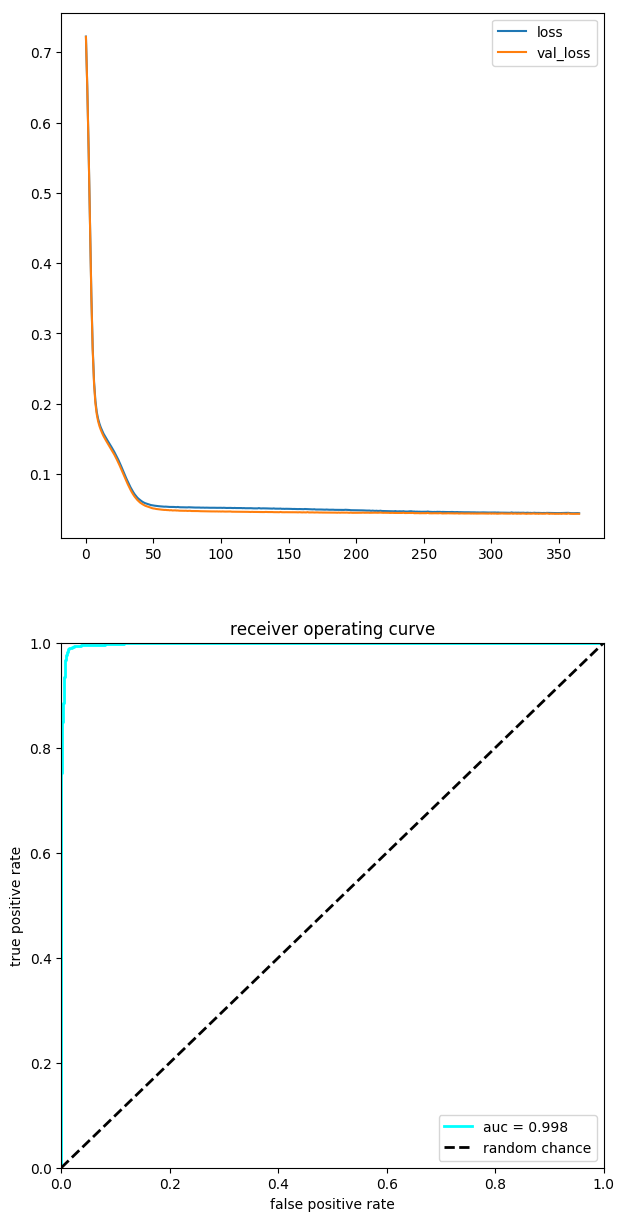

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(7,15))
    ax = plt.subplot(2, 1, 1)
    ax.plot(losses, label='loss')
    ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    
    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    #plt.figure(figsize=(7,7))
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax2.set_xlim([0, 1.0])
    ax2.set_ylim([0, 1.0])
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('receiver operating curve')
    ax2.legend(loc="lower right")
    plt.show()

In [41]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

myZI = np.zeros(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        data_point = torch.tensor([myXI[i,j], myYI[i,j]])
        myZI[i,j] = model(data_point)

(200, 200)


In [42]:
print(myZI)
myZI = model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.data.numpy().reshape(myXI.shape)

[[6.27192858e-05 6.65891494e-05 7.06976934e-05 ... 1.38604628e-09
  1.18896082e-09 1.01986830e-09]
 [6.49754220e-05 6.89844746e-05 7.32408735e-05 ... 1.46819312e-09
  1.25941257e-09 1.08031695e-09]
 [6.73127579e-05 7.14659545e-05 7.58754541e-05 ... 1.55520541e-09
  1.33405420e-09 1.14433751e-09]
 ...
 [9.40722823e-01 9.41072702e-01 9.41420674e-01 ... 7.95846028e-12
  5.97414436e-12 4.48449220e-12]
 [9.42445338e-01 9.42785800e-01 9.43124235e-01 ... 8.34294005e-12
  6.26274857e-12 4.70121381e-12]
 [9.44120705e-01 9.44451809e-01 9.44780946e-01 ... 8.74599525e-12
  6.56538235e-12 4.92833335e-12]]


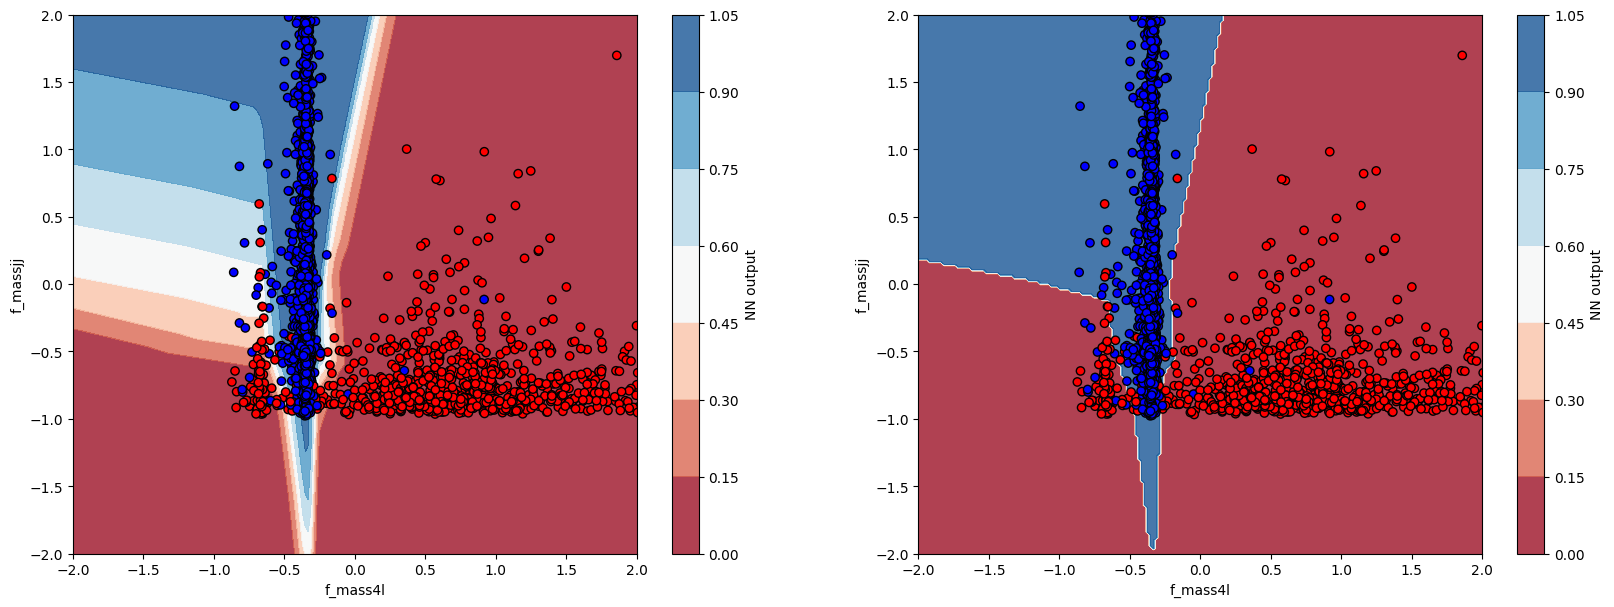

In [43]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')